In [1]:

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(1)

In [2]:
## dataset for chunk selection， 
## sample: a sequence of 0 or 1
## target: the number of chunks of 1-s in the sequence
## example: if X = 001001101 => y = 3 (3 chunks of ones)

import numpy as np

def sampler(length=10, batch=2):
    x = np.random.randint(0, 2, size=(batch, length))
                          
    y = x
    y1 = np.concatenate((y, np.zeros((batch, 1))), axis=1)
    y2 = np.concatenate((np.zeros((batch, 1)), y), axis=1)
    #print(y)
    #print(x, y)
    z = y1 - y2
    count = (z == 1).sum(axis=1)
    x = Variable(torch.Tensor(x)).cuda()
    count = Variable(torch.Tensor(count)).cuda()
    return x, count
    
    
sampler()

(Variable containing:
     0     0     1     1     0     0     0     1     1     0
     1     0     0     1     0     0     0     0     1     1
 [torch.cuda.FloatTensor of size 2x10 (GPU 0)], Variable containing:
  2
  3
 [torch.cuda.FloatTensor of size 2 (GPU 0)])

In [4]:

## LSTM BASELINE

class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=5, out_dim=1):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=1)

        self.hidden = self.init_hidden()
        
        self.hid2out = nn.Linear(hidden_dim, out_dim)
    def init_hidden(self, batch=1):
        return (Variable(torch.randn(1, batch, self.hidden_dim)).cuda(), 
                Variable(torch.randn(1, batch, self.hidden_dim)).cuda())
    

    def forward(self, sentence):
        batch_size = sentence.shape[0]
        time_dim = sentence.shape[1]
        hidden = self.init_hidden(batch_size)
        
        x = torch.transpose(sentence, 1, 0)
        x = x.unsqueeze(2)
        
        #print(x.shape)
        #print(hidden[0].shape)
        
        #for i in range(time_dim):
            #print(i)
        out, hidden = self.lstm(x, hidden)
        #print(out, hidden[0])
            #print(out.shape)
        #asdf = cwe
            
        #print(out.shape)
       #print(hidden[0].shape)
        x = self.hid2out(hidden[0])
        #print(out.shape)
        #print(hidden[0].shape)
        return x

data, label = sampler(length=10, batch=1)
model = LSTM().cuda()
x = model(data)
crit = torch.nn.MSELoss()



print(x)


Variable containing:
(0 ,.,.) = 
1.00000e-02 *
  -7.8520
[torch.cuda.FloatTensor of size 1x1x1 (GPU 0)]



In [28]:
def train(model, epoch=10000, low=3, high=20):
    EPOCH = epoch
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []
    for i in range(EPOCH):
        model.train()
        model.zero_grad()
        n = np.random.randint(low, high, size=1)[0]

        data, label = sampler(length=n, batch=10)
        pred = model(data)
        loss = crit(pred, label)
        loss.backward()
        optimizer.step()
        #print(i, loss.data[0])

        ##testing
        if i % 100 == 0:
            losses.append(loss.data[0])
            model.eval()
            data, label = sampler(length=20, batch=3)
            pred = model(data)
            #print(i, loss.data[0])
            loss = crit(pred, label)
    return losses

In [43]:
def test(model, high=60):
    length_losses = []
    for l in range(1, high):
        model.eval()
        data, label = sampler(length=l, batch=100)
        pred = model(data)
        #print(i, loss.data[0])
        loss = crit(pred, label)
        length_losses.append(loss.data.cpu().numpy())
        #print(loss)
    return length_losses


In [8]:
model = LSTM(hidden_dim=64).cuda()
losses = train(model)

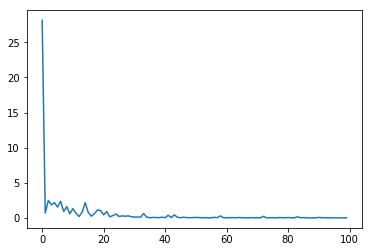

In [10]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [12]:
## test generalization to longer sequences than seen

length_losses = test(model)
plt.plot(length_losses)

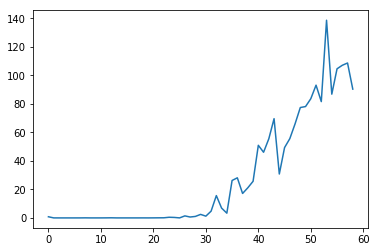

In [16]:
class RNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=5, out_dim=1):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        self.RNN = nn.RNN(input_dim, hidden_dim,
                            num_layers=1)

        self.hidden = self.init_hidden()
        
        self.hid2out = nn.Linear(hidden_dim, out_dim)
    def init_hidden(self, batch=1):
        return Variable(torch.randn(1, batch, self.hidden_dim)).cuda()
    

    def forward(self, sentence):
        batch_size = sentence.shape[0]
        time_dim = sentence.shape[1]
        hidden = self.init_hidden(batch_size)
        
        x = torch.transpose(sentence, 1, 0)
        x = x.unsqueeze(2)
        
        #print(x.shape)
        #print(hidden[0].shape)
        
        #for i in range(time_dim):
            #print(i)
        out, hidden = self.RNN(x, hidden)
        #print(out, hidden[0])
            #print(out.shape)
        #asdf = cwe
            
        #print(out.shape)
       #print(hidden[0].shape)
        x = self.hid2out(hidden[0])
        #print(out.shape)
        #print(hidden[0].shape)
        return x

data, label = sampler(length=10, batch=1)
model2 = RNN()
x = model(data)
print(x)
crit = torch.nn.MSELoss()

Variable containing:
(0 ,.,.) = 
  3.1637
[torch.cuda.FloatTensor of size 1x1x1 (GPU 0)]



In [24]:
model2 = RNN(hidden_dim=64).cuda()
losses = train(model2)
plt.plot(losses)

[2.3972432613372803, 1.576328992843628, 2.8992578983306885, 3.0965793132781982, 22.10491943359375, 9.503275871276855, 4.95547342300415, 5.128669261932373, 3.1165382862091064, 23.22134780883789, 4.181772708892822, 10.176953315734863, 7.755428314208984, 3.1849911212921143, 10.098631858825684, 13.695551872253418, 3.6670117378234863, 8.583684921264648, 5.523957252502441, 12.007253646850586, 1.9847869873046875, 15.779533386230469, 5.176953315734863, 5.089109897613525, 1.402148962020874, 3.1467087268829346, 50.746543884277344, 33.206016540527344, 1.4896323680877686, 34.8502197265625, 1.3576558828353882, 8.874223709106445, 3.1200528144836426, 2.700385332107544, 3.1027352809906006, 2.3405988216400146, 0.9549788236618042, 3.9595489501953125, 3.829484224319458, 2.374474048614502, 1.7799354791641235, 0.6591843366622925, 26.665456771850586, 5.262983798980713, 8.756444931030273, 0.9491024017333984, 1.729029893875122, 8.77349853515625, 7.087721824645996, 3.301741123199463, 3.9900734424591064, 2.6957

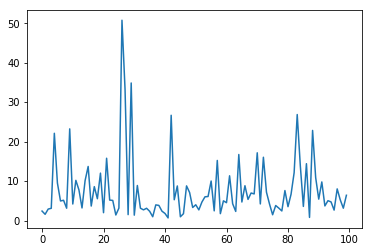

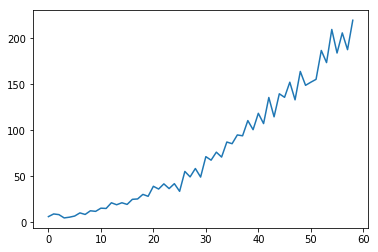

In [37]:
## test generalization to longer sequences than seen

length_losses = test(model2)

#print(pred.data.numpy().flatten())
#print(label.data.numpy())
#printdata.data.numpy())
#print('test loss:', loss.data[0])

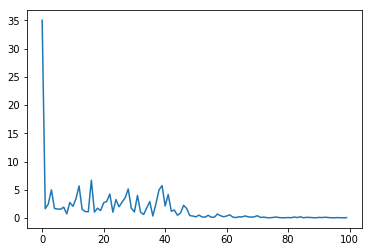

In [29]:
model = LSTM(hidden_dim=64).cuda()
losses = train(model, low=15, high=30)
plt.plot(losses)

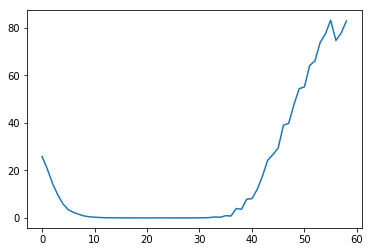

In [38]:
## test generalization to longer sequences than seen

length_losses = test(model)
plt.plot(length_losses)

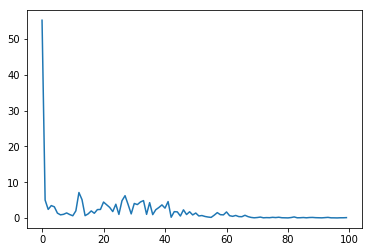

In [40]:
model = LSTM(hidden_dim=128).cuda()
losses = train(model, low=15, high=30)
plt.plot(losses)

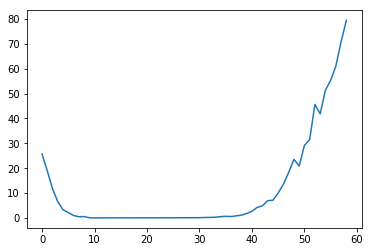

In [45]:
## test generalization to longer sequences than seen

length_losses = test(model)
plt.plot(length_losses)